__Batch run for zonal stats__ \
Tips from: https://gorelick.medium.com/fast-er-downloads-a2abd512aa26 \
Here, HydroLakes are the vectors, not BAWLD. Dataset is much larger and complicated.

## I/O

In [1]:
import os
from pathlib import Path
import multiprocessing
import numpy as np
from scipy.stats import binned_statistic

from retry import retry
import geopandas as gpd
import pandas as pd
import dask.dataframe as dd
import ee
import geemap
from matplotlib import pyplot as plt
import seaborn as sns


In [2]:
## I/O
modN = 300000
analysis_dir = '/mnt/g/Ch4/GSW_zonal_stats/HL/v2/'
os.makedirs(analysis_dir, exist_ok=True)

## Derived
# modstr = 'mod'+str(modN)

In [3]:
## Register with ee using high-valume (and high-latency) endpoint
ee.Initialize(opt_url='https://earthengine-highvolume.googleapis.com') # NOT 'https://earthengine.googleapis.com'

## Functions

In [4]:
def getRequests():
    ''' Based on unique lat/long indexes in BAWLD'''

    ## Load shapefile to join
    gdf_bawld = gpd.read_file('/mnt/g/Other/Kuhn-olefeldt-BAWLD/BAWLD/BAWLD_V1___Shapefile.zip')

    ## For test run: filter only a few tiles
    # gdf_bawld.query("(Lat > 59) and (Lat < 60) and (Long > -109) and (Long < -102)", inplace=True) # comment out

    return gdf_bawld[['Long', 'Lat']].to_numpy()

## testing
# foo = getRequests()
# for f in foo:
#     print(f)

# foo

In [5]:
@retry(tries=2, delay=1, backoff=3) # (tries=10, delay=1, backoff=2)
def getResult(index, group):
    """
    Handle the HTTP requests to download one result. index is python index and long is longitude, used for aggregation.
    index is placeholder
    group is an object that represents a unique value within a grouping (e.g. country name, grid cell longitude), and is not related to "group" in function geemap.zonal_statistics_by_group
    """
    ''' TODO: for real, filter to only Arctic X, change scale and tile scale X, change load gdf BB'''
    ## I/O
    out_dir = os.path.join(analysis_dir, 'tiles')
    out_pth = os.path.join(out_dir, f'HL_zStats_Oc_Long{group[0]}_Lat{group[1]}.csv')

    ## CRS (ist there a smarter way to do this?)
    crs = 'PROJCS["Lambert_Azimuthal_Equal_Area",GEOGCS["Unknown",DATUM["D_unknown",SPHEROID["Unknown",6371007.181,0]],PRIMEM["Greenwich",0],UNIT["Degree",0.017453292519943295]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_origin",45.5],PARAMETER["central_meridian",-114.125],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["Meter",1]]'
    # crs = 'PROJCS["WGS 84 / NSIDC EASE-Grid 2.0 North",GEOGCS["WGS 84",DATUM["WGS_1984",SPHEROID["WGS 84",6378137,298.257223563,AUTHORITY["EPSG","7030"]],AUTHORITY["EPSG","6326"]],PRIMEM["Greenwich",0,AUTHORITY["EPSG","8901"]],UNIT["degree",0.0174532925199433,AUTHORITY["EPSG","9122"]],AUTHORITY["EPSG","4326"]],PROJECTION["Lambert_Azimuthal_Equal_Area"],PARAMETER["latitude_of_center",90],PARAMETER["longitude_of_center",0],PARAMETER["false_easting",0],PARAMETER["false_northing",0],UNIT["metre",1,AUTHORITY["EPSG","9001"]],AUTHORITY["EPSG","6931"]]'

    ## Load vect and compute mod of ID variable to use for grouping, filtering to high latitudes
    vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10") #.filter("Pour_lat > 45.0") #.map(addMod)

    # For testing: Filter  to reduce size of operation
    # vectF = vectF.filter("Pour_lat > 59.55").filter("Pour_lat < 59.56") #.filter("Long == -126.25")
    # vect = vect.filter("Hylak_id < 500").filter("Lake_area < 1000")
    
    ## Load GSW
    gsw = ee.Image("JRC/GSW1_4/GlobalSurfaceWater")
    occurrence = gsw.select('occurrence')

    ## Filter based on bawld cell geometry (note: cells are unequal area)
    # vectF = vect.filter(ee.Filter.eq(modstr, group))
    # groupEE = [ee.Number.float(group[0]) , ee.Number.float(group[1])] # list(map(ee.Number.float, group)) # convert to server object
    vectF = vect.filter(ee.Filter.And(ee.Filter.expression(f"(Pour_long > {group[0]-0.25}) && (Pour_long <= {group[0]+0.25})"), 
        ee.Filter.And(ee.Filter.expression(f"(Pour_lat > {group[1]-0.25}) && (Pour_lat <= {group[1]+0.25})"))))
    nFeats = vectF.size().getInfo()
    print(f'Number of features in chunk: {nFeats}')
    # print(vect.size())
    # print(vectF.size())
    # statistics_type can be either 'SUM' or 'PERCENTAGE'
    # denominator can be used to convert square meters to other areal units, such as square kilometers
    if nFeats != 0:
        geemap.zonal_statistics_by_group(
            occurrence,
            vectF,
            out_pth,
            statistics_type='SUM',
            denominator=1000000,
            decimal_places=3,
            crs=crs,
            scale=30, # meters, specifiy to compute at native res (default would be 300m)
            tile_scale=8 # default is 1, increase number to reduce chunking tile size (it won't affect results, but will take longer and use less mem)
        )
        print("Done with group: ", group)
    else:
        print('No features within region filtered by group.')
        Path(out_pth + '.txt').touch()

## Apply functions via GEE calls in parallel

In [6]:
## Testing
# vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10").map(addMod)
# print(vect.filter("Hylak_id < 500").filter("Lake_area < 1000").size().getInfo())
# print('Number of features in chunk: ', vect.filter("Hylak_id < 1000").size())
# vect.first().get('mod50')
# vect.propertyNames()
# vect.first().propertyNames() # to actually print the result!
# vect.get('mod50')

In [7]:
## Test on single (Error: property 'element' is required means some filter returned zero. )
# getResult(3, 1)
# getResult(0, np.array([-104.25, 51.25]))

In [8]:
## View expected number of results
items = getRequests()
# print(f'Number of items: {len(items)}')

ERROR 1: PROJ: proj_create_from_database: Open of /home/ekyzivat/mambaforge/envs/geospatial/share/proj failed


In [9]:
print(f'Number of items: {len(items)}')

Number of items: 23469


In [10]:
## Run function
# items = getRequests() # a list whose length is the number of groups to use for parallelizing # np.arange(modN) #
print(f'Sending request in {len(items)} chunks...')
pool = multiprocessing.Pool(25)
pool.starmap(getResult, enumerate(items))
pool.close()
pool.join()

Sending request in 23469 chunks...
Number of features in chunk: 0
No features within region filtered by group.
Number of features in chunk: 0
No features within region filtered by group.
Number of features in chunk: 0Number of features in chunk: 0

No features within region filtered by group.No features within region filtered by group.

Number of features in chunk: 27
Number of features in chunk: 0
No features within region filtered by group.
Number of features in chunk: 26
Number of features in chunk: 63
Number of features in chunk: 8
Number of features in chunk: 0
No features within region filtered by group.
Number of features in chunk: 267
Number of features in chunk: 281
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Computing (Hi Ethan!)... 
Number of features in chunk: 10
Number of features in chunk: 0
No features within region filtered by group.
Number of features in chunk: 72
Number of features i

Exception: The service is currently unavailable.

## Load and piece together

In [11]:
# Load files using dask
# from https://mungingdata.com/pandas/read-multiple-csv-pandas-dataframe/
tile_dir = os.path.join(analysis_dir, 'tiles')
ddf = dd.read_csv(f"{tile_dir}/*.csv", assume_missing=True, dtype={'system:index': 'object', 'Lake_name': 'object'}) # latter argument suggested by dask error and it fixes it!

In [12]:
## convert to pandas df
df = ddf.compute()
df = df.reset_index().drop('index', axis=1)
df

Class_70  Class_71  Class_72  Class_73  Class_74  Class_75  Class_76  \
0           0.001     0.002     0.000     0.001     0.001     0.000     0.003   
1           0.000     0.000     0.000     0.000     0.000     0.001     0.001   
2           0.003     0.000     0.000     0.001     0.001     0.001     0.000   
3           0.000     0.000     0.000     0.000     0.001     0.001     0.000   
4           0.001     0.000     0.001     0.001     0.000     0.000     0.003   
...           ...       ...       ...       ...       ...       ...       ...   
1042679       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1042680       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1042681       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1042682       NaN       NaN       NaN       NaN       NaN       NaN       NaN   
1042683       NaN       NaN       NaN       NaN       NaN       NaN       NaN   

         Class_77  Class_sum  Class_8  ...  Vol_res   Dis_avg   Pour_lat  \
0           0.001      0.247    0.000  ...      0.0     0.131  50.391481   
1           0.005      0.098    0.005  ...      0.0     3.071  50.121770   
2           0.003      0.347    0.001  ...      0.0     0.005  50.490288   
3           0.002      0.099    0.001  ...      0.0     0.001  50.485042   
4           0.003      0.135    0.000  ...      0.0     0.001  50.357718   
...           ...        ...      ...  ...      ...       ...        ...   
1042679       NaN      0.000      NaN  ...      0.0     0.000  79.639685   
1042680       NaN      0.000      NaN  ...      0.0 -9999.000  79.627083   
1042681       NaN      0.000      NaN  ...      0.0     0.695  79.532163   
1042682       NaN      0.000      NaN  ...      0.0     2.251  79.580108   
1042683       NaN      0.000      NaN  ...      0.0     0.002  79.663504   

         Vol_src  Country  Lake_name          system:index  Class_98  \
0            3.0   Canada        NaN  001b0000000000004e0d       NaN   
1            3.0   Canada        NaN  001b00000000000051b5       NaN   
2            3.0   Canada        NaN  001b0000000000004c9d       NaN   
3            3.0   Canada        NaN  001b0000000000004cb5       NaN   
4            3.0   Canada        NaN  001b0000000000004e80       NaN   
...          ...      ...        ...                   ...       ...   
1042679      3.0   Russia        NaN  001f0000000000008301       NaN   
1042680      3.0   Russia        NaN  001f0000000000008305       NaN   
1042681      3.0   Russia        NaN  001f00000000000079b8       NaN   
1042682      3.0   Russia        NaN  001f000000000000830d       NaN   
1042683      3.0   Russia        NaN  001f00000000000079b6       NaN   

         Class_99  Class_100  
0             NaN        NaN  
1             NaN        NaN  
2             NaN        NaN  
3             NaN        NaN  
4             NaN        NaN  
...           ...        ...  
1042679       NaN        NaN  
1042680       NaN        NaN  
1042681       NaN        NaN  
1042682       NaN        NaN  
1042683       NaN        NaN  

[1042684 rows x 124 columns]

## Bin GSW in 4 bins

In [13]:
## Mask in occurence columns and change values to int
oc_columns = list(map(lambda c: ('Class_' in c) and ('sum' not in c), df.columns)) # occurrence columns positive mask. use map function, rather than for loop, for practice!
oc_column_vals = list(map(lambda c: int(c.replace('Class_', '')), df.columns[oc_columns])) # all relevant occurance fields converted to ints, as a list
# oc_column_vals

In [14]:
bStat = binned_statistic(oc_column_vals, values=df.iloc[:, oc_columns], statistic=np.nansum, bins=[0, 5, 50, 95, 100]) # 
bStat

BinnedStatisticResult(statistic=array([[0.001, 0.013, 0.233, 0.   ],
       [0.032, 0.035, 0.031, 0.   ],
       [0.001, 0.026, 0.32 , 0.   ],
       ...,
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ],
       [0.   , 0.   , 0.   , 0.   ]]), bin_edges=array([  0.,   5.,  50.,  95., 100.]), binnumber=array([3, 3, 3, 3, 3, 3, 3, 3, 2, 3, 2, 3, 2, 1, 1, 1, 1, 1, 2, 2, 3, 3,
       3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 4, 4, 4, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2, 2, 2, 2, 2, 2, 2, 2,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3,
       2, 2, 2, 2, 2, 2, 2, 2, 2, 2, 4, 4, 4]))

In [15]:
bin_labels = ['0-5', '5-50', '50-95', '95-100']
dfB = pd.DataFrame(bStat.statistic, columns=bin_labels) / pd.DataFrame(df.loc[:,'Class_sum']).values * 100 #, index=df.index) # df binned
dfB['Hylak_id'] = df.Hylak_id
dfB['Class_sum'] = df.Class_sum
dfB 

0-5       5-50      50-95  95-100   Hylak_id  Class_sum
0         0.404858   5.263158  94.331984     0.0   955819.0      0.247
1        32.653061  35.714286  31.632653     0.0   961301.0      0.098
2         0.288184   7.492795  92.219020     0.0   953353.0      0.347
3        11.111111  39.393939  49.494949     0.0   953479.0      0.099
4         0.740741  22.962963  76.296296     0.0   956619.0      0.135
...            ...        ...        ...     ...        ...        ...
1042679        NaN        NaN        NaN     NaN  1119786.0      0.000
1042680        NaN        NaN        NaN     NaN  1119794.0      0.000
1042681        NaN        NaN        NaN     NaN   124072.0      0.000
1042682        NaN        NaN        NaN     NaN  1119814.0      0.000
1042683        NaN        NaN        NaN     NaN   124068.0      0.000

[1042684 rows x 6 columns]

## Load shapefile and join in GSW values (full and binned)

In [16]:
## Load shapefile to join
gdf = gpd.read_file('/mnt/f/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10_shp/HydroLAKES_polys_v10.shp', bbox=(-180, 40, 180, 90)) # bbox can speed loading


In [17]:
## Filter columns
cols_to_keep = df.columns[[('Class' in c) or ('Hylak_id' in c) for c in df.columns]]

In [18]:

## Merge files
gdf_join_full = gdf.merge(df[cols_to_keep], left_on='Hylak_id', right_on='Hylak_id', how='inner', validate='one_to_one')

In [19]:
## Write out full shapefile
gdf_join_full_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_full.shp')
gdf_join_full.to_file(gdf_join_full_pth)

In [20]:
gdf.columns

Index(['Hylak_id', 'Lake_name', 'Country', 'Continent', 'Poly_src',
       'Lake_type', 'Grand_id', 'Lake_area', 'Shore_len', 'Shore_dev',
       'Vol_total', 'Vol_res', 'Vol_src', 'Depth_avg', 'Dis_avg', 'Res_time',
       'Elevation', 'Slope_100', 'Wshd_area', 'Pour_long', 'Pour_lat',
       'geometry'],
      dtype='object')

In [21]:
## Merge binned file to bawld gdf (only keep a few original attributes)
gdf_join_binned = gdf.merge(dfB, left_on='Hylak_id', right_on='Hylak_id', how='inner', validate='one_to_one') # ['Cell_ID', 'Long', 'Lat', 'Area_Pct', 'Shp_Area', 'WETSCAPE', 'geometry']
gdf_join_binned

Hylak_id Lake_name                   Country      Continent Poly_src  \
0               4  Winnipeg                    Canada  North America   CanVec   
1              10    Ladoga                    Russia         Europe    MODIS   
2              11    Baikal                    Russia         Europe     SWBD   
3              19   Selawik  United States of America  North America    Other   
4              21  Takiyuak                    Canada  North America   CanVec   
...           ...       ...                       ...            ...      ...   
1042679   1354300      None                    Russia         Europe     SWBD   
1042680   1354316      None                    Russia         Europe     SWBD   
1042681   1354345      None                    Russia         Europe     SWBD   
1042682   1356821      None                    Russia         Europe     SWBD   
1042683   1357252      None                    Russia         Europe     SWBD   

         Lake_type  Grand_id  Lake_area  Shore_len  Shore_dev  ...  Slope_100  \
0                3       709   23923.04    4018.32       7.33  ...      -1.00   
1                1         0   17444.01    1795.84       3.84  ...      -1.00   
2                3      5058   31967.85    2688.05       4.24  ...      -1.00   
3                1         0    1058.07     170.52       1.48  ...      -1.00   
4                1         0    1031.69    1003.96       8.82  ...      -1.00   
...            ...       ...        ...        ...        ...  ...        ...   
1042679          1         0       0.10       1.38       1.26  ...       5.46   
1042680          1         0       0.16       2.73       1.92  ...       6.97   
1042681          1         0       0.24       3.73       2.16  ...       7.48   
1042682          1         0       0.30       4.63       2.38  ...      13.02   
1042683          1         0       0.18       1.94       1.29  ...      11.38   

         Wshd_area   Pour_long   Pour_lat  \
0         919611.5  -97.863542  53.696359   
1         279581.2   31.032851  59.952780   
2         569176.2  104.321875  52.234393   
3          30059.9 -161.218750  66.577083   
4           7177.5 -113.658891  66.212040   
...            ...         ...        ...   
1042679        4.7  143.565851  46.388284   
1042680        1.5  143.586458  46.385559   
1042681        2.1  143.593029  46.379939   
1042682       38.1  149.792708  45.857083   
1042683        2.8  149.677083  45.739339   

                                                  geometry       0-5  \
0        POLYGON ((-98.80636 53.88021, -98.80578 53.880...  0.014780   
1        POLYGON ((30.88438 61.74966, 30.88663 61.74813...  0.010660   
2        POLYGON ((109.74514 55.86611, 109.74541 55.865...  0.027175   
3        POLYGON ((-160.81470 66.65479, -160.76426 66.6...  0.009886   
4        POLYGON ((-112.94925 66.55554, -112.94671 66.5...  0.168389   
...                                                    ...       ...   
1042679  POLYGON ((143.56489 46.38470, 143.56472 46.384...  3.846154   
1042680  POLYGON ((143.58455 46.38664, 143.58522 46.386...  2.027027   
1042681  POLYGON ((143.60276 46.38213, 143.60392 46.380...  2.955665   
1042682  POLYGON ((149.79378 45.85818, 149.79374 45.857...  2.097902   
1042683  POLYGON ((149.68230 45.73857, 149.68250 45.737...  0.606061   

              5-50      50-95     95-100  Class_sum  
0         0.126545   0.389371  99.469304  23992.262  
1         0.170701   2.015416  97.803223  17439.821  
2         0.171015   0.988376  98.813434  32070.197  
3         0.290164  11.685068  88.014883   1062.159  
4         0.575596  85.322688  13.933326   1035.101  
...            ...        ...        ...        ...  
1042679  42.307692  50.000000   3.846154      0.078  
1042680  27.027027  39.189189  29.054054      0.148  
1042681  27.586207  35.960591  32.019704      0.203  
1042682  10.489510  76.923077   8.041958      0.286  
1042683   1.212121  58.181818  38.181818      0.165  

[1042684

In [22]:
## Write out binned shapefile
gdf_join_binned_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_binned.shp')
gdf_join_binned.to_file(gdf_join_binned_pth)

## Histogram plots

In [ ]:
## load if necessary (previously defined vars)
# gdf_join_full_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_full.shp')
# gdf_join_full = gpd.read_file(gdf_join_full_pth)

# gdf_join_binned_pth = os.path.join(analysis_dir, 'HL_zStats_Oc_binned.shp')
# gdf_join_binned = gpd.read_file(gdf_join_binned_pth)

# bin_labels = ['0-5', '5-50', '50-95', '95-100']


In [23]:
## Preprocess to remove any nan's in important columns
gdf_join_binnedF = gdf_join_binned.dropna(subset=bin_labels) # filtered
print(f'Dropped {gdf_join_binned.shape[0] - gdf_join_binnedF.shape[0]} rows with nans.')
## Take weighted average
weightAvg = np.average(gdf_join_binnedF[bin_labels], weights = gdf_join_binnedF['Lake_area'], axis=0)
# weightAvg = np.average(gdf_join_binned[bin_labels], axis=0)

weightAvg

Dropped 10296 rows with nans.


array([ 0.64925191,  5.53651614, 56.45950758, 37.34613875])

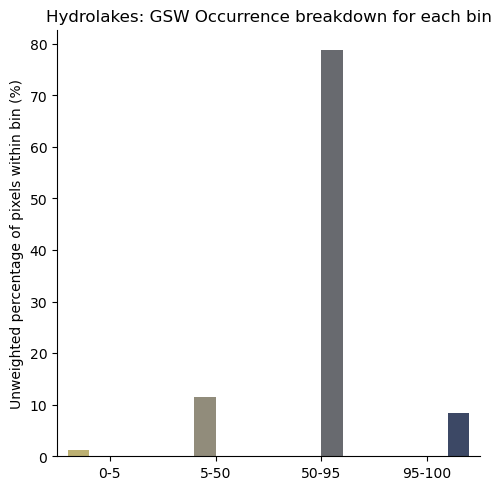

In [24]:
## Plot
## Reshape (melt) and plot as grouped bar plot
"Within all of one occurrence bin, what was the contribution of LEV values"
g = sns.catplot(gdf_join_binned[['Hylak_id']+bin_labels].melt(id_vars='Hylak_id', var_name='Occurrence bin'),\
     hue = 'Occurrence bin', y='value', x='Occurrence bin', kind='bar', palette='cividis_r', errorbar=('ci', 95))
g.set_axis_labels('', 'Unweighted percentage of pixels within bin (%)')
g.set(title=f'Hydrolakes: GSW Occurrence breakdown for each bin')

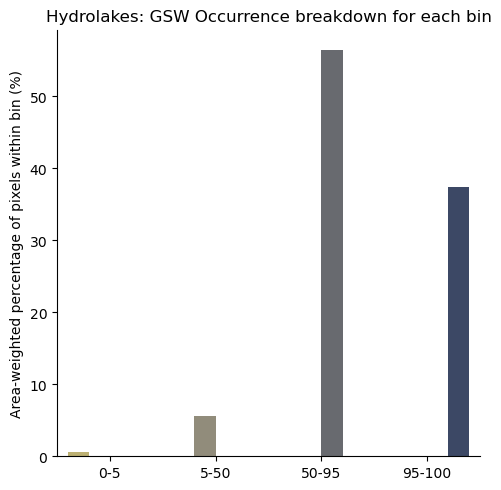

In [25]:
## Weighted average histogram/barplot
dfWA = pd.DataFrame([weightAvg, bin_labels], index=['value','bin']).T
g = sns.catplot(dfWA, hue = 'bin', y='value', x='bin', kind='bar', palette='cividis_r')
g.set_axis_labels('', 'Area-weighted percentage of pixels within bin (%)')
g.set(title=f'Hydrolakes: GSW Occurrence breakdown for each bin')

In [26]:
## TODO: add sns 95% CI by converting percentages to km2, summing, then normalizing

Text(0, 0.5, 'Unweighted percentage of pixels within bin (%)')

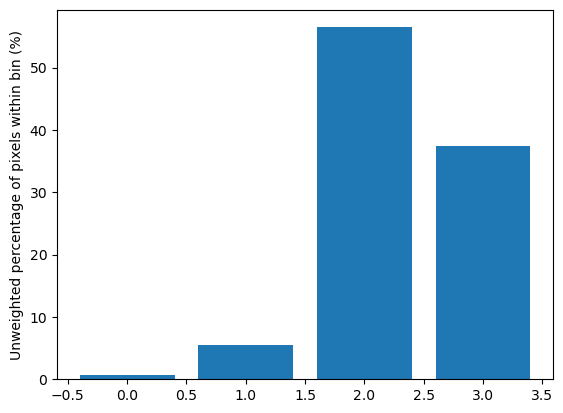

In [27]:
## Weighted average histogram/barplot (alternate using MPL)

plt.bar(x=np.arange(4), height=weightAvg)
plt.ylabel( 'Unweighted percentage of pixels within bin (%)')


## Scrap

In [ ]:
def getRequests():
    """Generates a list of work items to be downloaded. Should be dquivalent to 'return modN', where modN is mod number.
    """    
    ## Load vector dataset
    vect = ee.FeatureCollection("projects/sat-io/open-datasets/HydroLakes/lake_poly_v10").map(addMod)

    # For testing: Filter  to reduce size of operation
    # vectv = vect.filter("Pour_lat > 59.5").filter("Pour_lat < 59.6") #.filter("Long == -126.25")

    ## Aggregate by Hylak_id mod
    # return np.unique(vectF.aggregate_array('Country').getInfo()) # change to vect not vectF for real run
    return np.unique(vect.aggregate_array(modstr).getInfo()) # change to vect not vectF for real run

In [ ]:
def getRequests():
    ''' shortcut function that doesn't take 2.5 minutes.'''
    return range(modN)

In [ ]:
def addMod(feature):
    '''Adds a new mod[n] column to FeatureCollection'''
    mod = modN # defined at beginning
    modComputed = ee.Number(feature.get('Hylak_id')).mod(mod) # ee.Number.parse(
    return feature.set('mod'+str(mod), modComputed) # .double()

## ERRORS

```python
Computing (Hi Ethan!)... 
Output exceeds the size limit. Open the full output data in a text editor
---------------------------------------------------------------------------
HttpError                                 Traceback (most recent call last)
File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py:328, in _execute_cloud_call(call, num_retries)
    327 try:
--> 328   return call.execute(num_retries=num_retries)
    329 except googleapiclient.errors.HttpError as e:

File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/_helpers.py:130, in positional.<locals>.positional_decorator.<locals>.positional_wrapper(*args, **kwargs)
    129         logger.warning(message)
--> 130 return wrapped(*args, **kwargs)

File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/http.py:938, in HttpRequest.execute(self, http, num_retries)
    937 if resp.status >= 300:
--> 938     raise HttpError(resp, content, uri=self.uri)
    939 return self.postproc(resp, content)

HttpError: <HttpError 400 when requesting https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json returned "User memory limit exceeded.". Details: "User memory limit exceeded.">

During handling of the above exception, another exception occurred:

EEException                               Traceback (most recent call last)
File ~/mambaforge/envs/geospatial/lib/python3.10/site-packages/geemap/common.py:6961, in zonal_stats_by_group(in_value_raster, in_zone_vector, out_file_path, statistics_type, decimal_places, denominator, scale, crs, tile_scale, return_fc, verbose, timeout, proxies, **kwargs)
   6960     else:
-> 6961         ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
   6963 except Exception as e:
...
   6961         ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
   6963 except Exception as e:
-> 6964     raise Exception(e)

Exception: User memory limit exceeded.

```python
Output exceeds the size limit. Open the full output data in a text editor
---------------------------------------------------------------------------
RemoteTraceback                           Traceback (most recent call last)
RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 328, in _execute_cloud_call
    return call.execute(num_retries=num_retries)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/_helpers.py", line 130, in positional_wrapper
    return wrapped(*args, **kwargs)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/http.py", line 938, in execute
    raise HttpError(resp, content, uri=self.uri)
googleapiclient.errors.HttpError: <HttpError 429 when requesting https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json returned "Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.". Details: "Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.">

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/multiprocessing/pool.py", line 125, in worker
    result = (True, func(*args, **kwds))
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/multiprocessing/pool.py", line 51, in starmapstar
    return list(itertools.starmap(args[0], args[1]))
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/decorator.py", line 232, in fun
    return caller(func, *(extras + args), **kw)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/retry/api.py", line 73, in retry_decorator
    return __retry_internal(partial(f, *args, **kwargs), exceptions, tries, delay, max_delay, backoff, jitter,
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/retry/api.py", line 33, in __retry_internal
...
    772     return self._value
    773 else:
--> 774     raise self._value

EEException: Too Many Requests: Request was rejected because the request rate or concurrency limit was exceeded.

Some error about element has a missing property. I treated it like an error caused by returning an empty table/feature collection and it seemed to resolve it.

This happened after 7 hrs of running (with 22,065 files generated)
```python
Downloading data from https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/tables/356e1d94dc202d39f9c68cc224730aa3-c7c5ab24b3d58dd6aa199d1a90b902e0:getFeatures
Please wait ...
Data downloaded to /mnt/g/Ch4/GSW_zonal_stats/HL/v2/tiles/HL_zStats_Oc_Long-159.75_Lat55.75.csv
Done with group:  [-159.75   55.75]
Output exceeds the size limit. Open the full output data in a text editor
---------------------------------------------------------------------------
RemoteTraceback                           Traceback (most recent call last)
RemoteTraceback: 
"""
Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 328, in _execute_cloud_call
    return call.execute(num_retries=num_retries)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/_helpers.py", line 130, in positional_wrapper
    return wrapped(*args, **kwargs)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/googleapiclient/http.py", line 938, in execute
    raise HttpError(resp, content, uri=self.uri)
googleapiclient.errors.HttpError: <HttpError 503 when requesting https://earthengine-highvolume.googleapis.com/v1alpha/projects/earthengine-legacy/value:compute?prettyPrint=false&alt=json returned "The service is currently unavailable.". Details: "The service is currently unavailable.">

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geemap/common.py", line 6962, in zonal_stats_by_group
    ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/geemap/common.py", line 1523, in ee_export_vector
    selectors = ee_object.first().propertyNames().getInfo()
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/computedobject.py", line 98, in getInfo
    return data.computeValue(self)
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 764, in computeValue
    return _execute_cloud_call(
  File "/home/ekyzivat/mambaforge/envs/geospatial/lib/python3.10/site-packages/ee/data.py", line 330, in _execute_cloud_call
...
   6962         ee_export_vector(final_result, filename, timeout=timeout, proxies=proxies)
   6964 except Exception as e:
-> 6965     raise Exception(e)

Exception: The service is currently unavailable.